In [1]:
"""
Minimum Dominating Set — Experimental Evaluation
Implements:
  1. Brute Force (exact)
  2. Greedy Approximation
  3. Degree-based Heuristic
Generates synthetic graphs, runs all algorithms,
and plots runtime and solution quality.
"""

import itertools
import time
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
# ---------- Algorithms ---------- #

def is_dominating_set(G, S):
    #check if s is domination set
    dominated = set(S)
    for v in S:
        dominated.update(G.neighbors(v))
    return len(dominated) == len(G)


def brute_force_mds(G, timeout=300):
    """Brute Force exact search for Minimum Dominating Set."""
    start = time.perf_counter()
    best_set = None
    n = len(G)
    vertices = list(G.nodes())

    for r in range(1, n + 1):
        for subset in itertools.combinations(vertices, r):
            if time.perf_counter() - start > timeout:
                return None, None  # timed out
            if is_dominating_set(G, subset):
                return subset, time.perf_counter() - start  # smallest found
    return best_set, time.perf_counter() - start

In [3]:
import itertools
import time

def is_dominating_set(G, S):
    """Check if S is a dominating set of graph G."""
    dominated = set(S)
    for v in S:
        dominated.update(G.neighbors(v))
    return len(dominated) == len(G)


def brute_force_mds(G, timeout=300):
   
    start = time.perf_counter()
    n = len(G)
    vertices = list(G.nodes())
    best_set = None

    for r in range(1, n + 1):  # gradually increase subset size
        found_any = False
        for subset in itertools.combinations(vertices, r):
            # if time.perf_counter() - start > timeout:
            #     print("Timeout reached during brute-force search.")
            #     return best_set, None  # timed out

            if is_dominating_set(G, subset):
                # record first valid subset of this size
                if best_set is None or len(subset) < len(best_set):
                    best_set = subset
                found_any = True
        # if any dominating set found at this size, no need to go larger
        if found_any:
            break

    elapsed = time.perf_counter() - start
    return best_set, elapsed


In [4]:
def greedy_mds(G):
    """Greedy approximation algorithm (set-cover style)."""
    start = time.perf_counter()
    dominated = set()
    D = set()

    while len(dominated) < len(G):
        best_v, best_gain = None, -1
        for v in G.nodes():
            if v in D:
                continue
            gain = len(set(G.neighbors(v)) | {v} - dominated)
            if gain > best_gain:
                best_v, best_gain = v, gain
        D.add(best_v)
        dominated.update(set(G.neighbors(best_v)) | {best_v})
    return D, time.perf_counter() - start

In [5]:
def degree_heuristic_mds(G):
    """Degree-based heuristic algorithm."""
    start = time.perf_counter()
    D = set()
    dominated = set()
    sorted_vertices = sorted(G.degree, key=lambda x: x[1], reverse=True)

    for v, _ in sorted_vertices:
        if v not in dominated:
            D.add(v)
            dominated.update(G.neighbors(v))
            dominated.add(v)
        if len(dominated) == len(G):
            break
    return D, time.perf_counter() - start


In [26]:
# ---------- Experiment Setup ---------- #

def run_experiment(n_values=range(10,20,2), p=0.1, seeds=range(1)):
    """Runs BF, Greedy, and Heuristic on small graphs."""
    results = []

    for n in n_values:
        for seed in seeds:
            G = nx.erdos_renyi_graph(n, p, seed=seed)
            m = G.number_of_edges()

            # Brute Force
            bf_set, bf_time = brute_force_mds(G, timeout=60)
            greedy_set, greedy_time = greedy_mds(G)
            heu_set, heu_time = degree_heuristic_mds(G)

            # Approximation factors
            if bf_set is not None:
                bf_size = len(bf_set)
                greedy_factor = len(greedy_set) / bf_size
                heu_factor = len(heu_set) / bf_size
            else:
                bf_size = None
                greedy_factor = None
                heu_factor = None

            print("\n\nintermadite steps:", {"n": n, "m": m, "seed": seed,
                "bf_size": bf_size, "bf_time": bf_time,
                "greedy_size": len(greedy_set), "greedy_time": greedy_time,
                "heu_size": len(heu_set), "heu_time": heu_time,
                "greedy_factor": greedy_factor, "heu_factor": heu_factor})
            
            results.append({
                "n": n, "m": m, "seed": seed,
                "bf_size": bf_size, "bf_time": bf_time,
                "greedy_size": len(greedy_set), "greedy_time": greedy_time,
                "heu_size": len(heu_set), "heu_time": heu_time,
                "greedy_factor": greedy_factor, "heu_factor": heu_factor
            })
        

    df = pd.DataFrame(results)
    return df

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(df, out_prefix="mds"):
   
    # Ensure 'n' exists
    if "n" not in df.columns:
        raise KeyError("'n' column not found in the results DataFrame.")

    # Columns we might plot
    runtime_cols = ["bf_time", "greedy_time", "heu_time"]
    size_cols = ["bf_size", "greedy_size", "heu_size"]

    # Coerce to numeric where possible (None -> NaN)
    for c in runtime_cols + size_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Group by n, compute mean of numeric columns
    grouped = df.groupby("n", as_index=True).mean(numeric_only=True)

    # ----- Runtime plot -----
    plt.figure(figsize=(8,5))
    plotted_any = False
    for col in runtime_cols:
        if col in grouped.columns and grouped[col].notna().any():
            plt.plot(grouped.index, grouped[col], marker='o', label=col.replace("_", " ").title())
            plotted_any = True

    if plotted_any:
        plt.xlabel("Number of vertices (n)")
        plt.ylabel("Runtime (s)")
        plt.title("Runtime Comparison")
        plt.yscale("log")         # runtime often spans orders of magnitude
        plt.grid(True, which="both", ls="--", lw=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{out_prefix}_runtime_comparison.png", dpi=300)
        plt.show()
    else:
        print("No runtime data available to plot.")

    # ----- Solution size plot -----
    plt.figure(figsize=(8,5))
    plotted_any = False
    for col in size_cols:
        if col in grouped.columns and grouped[col].notna().any():
            plt.plot(grouped.index, grouped[col], marker='o', label=col.replace("_", " ").title())
            plotted_any = True

    if plotted_any:
        plt.xlabel("Number of vertices (n)")
        plt.ylabel("Size of Dominating Set")
        plt.title("Solution Size Comparison")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{out_prefix}_solution_size_comparison.png", dpi=300)
        plt.show()
    else:
        print("No solution-size data available to plot.")




intermadite steps: {'n': 10, 'm': 2, 'seed': 0, 'bf_size': 8, 'bf_time': 0.0026630000065779313, 'greedy_size': 10, 'greedy_time': 9.309999586548656e-05, 'heu_size': 8, 'heu_time': 1.9500002963468432e-05, 'greedy_factor': 1.25, 'heu_factor': 1.0}


intermadite steps: {'n': 12, 'm': 3, 'seed': 0, 'bf_size': 9, 'bf_time': 0.012004999996861443, 'greedy_size': 12, 'greedy_time': 0.0001036000030580908, 'heu_size': 9, 'heu_time': 3.609999839682132e-05, 'greedy_factor': 1.3333333333333333, 'heu_factor': 1.0}


intermadite steps: {'n': 14, 'm': 4, 'seed': 0, 'bf_size': 10, 'bf_time': 0.05274550001195166, 'greedy_size': 14, 'greedy_time': 0.00013010000111535192, 'heu_size': 10, 'heu_time': 4.569999873638153e-05, 'greedy_factor': 1.4, 'heu_factor': 1.0}


intermadite steps: {'n': 16, 'm': 7, 'seed': 0, 'bf_size': 10, 'bf_time': 0.2268214999930933, 'greedy_size': 16, 'greedy_time': 0.00017420000222045928, 'heu_size': 10, 'heu_time': 3.71999922208488e-05, 'greedy_factor': 1.6, 'heu_factor': 1.0}


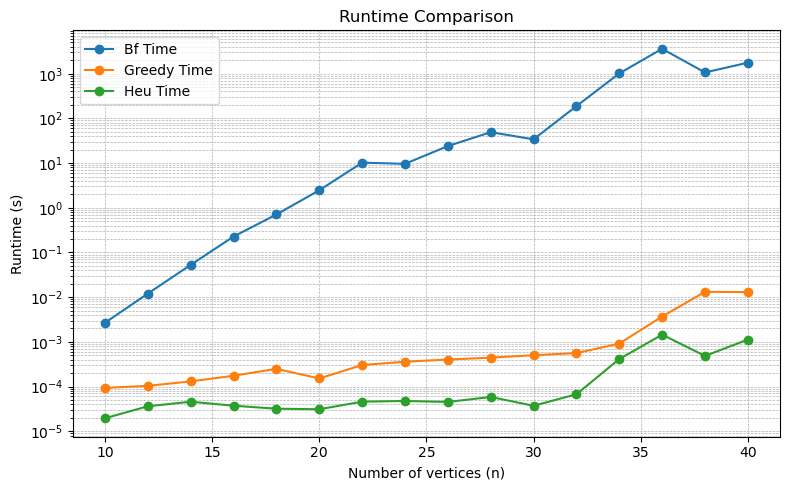

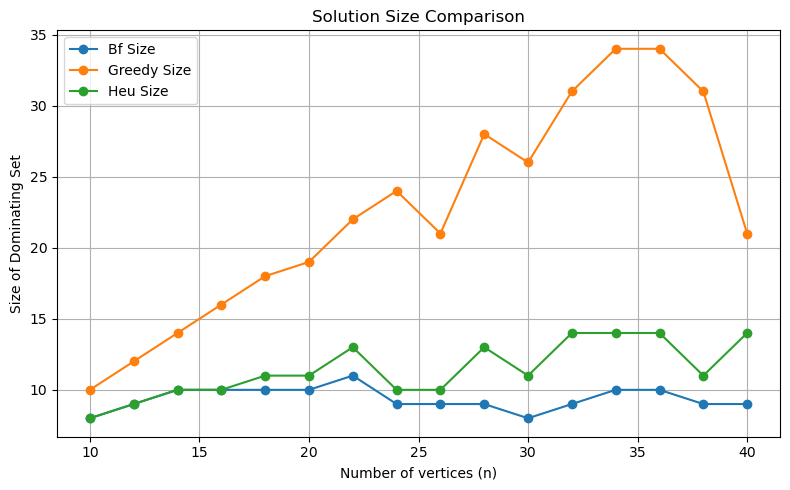


Results saved to 'mds_results.csv' and plots saved as PNG files.


In [29]:
# ---------- Main ---------- #
if __name__ == "__main__":
    df = run_experiment(n_values=range(10,42,2), p=0.1, seeds=range(1))
    df.to_csv("mds_results.csv", index=False)
    print(df)
    plot_results(df)
    print("\nResults saved to 'mds_results.csv' and plots saved as PNG files.")

In [9]:
# print("Columns:", df.columns.tolist())
print(df)
df.to_csv('small_graph.csv', index=False, encoding='utf-8')

    n  m  seed  bf_size   bf_time  greedy_size  greedy_time  heu_size  \
0  10  2     0        8  0.002672           10      0.00006         8   

   heu_time  greedy_factor  heu_factor  
0   0.00004           1.25         1.0  
